# New notebook

In [1]:
import os

# standard libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF

# image processing
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_li
from skimage.measure import find_contours

# custom library
from patchnmf.analyse.nmf import downsample_tiff_avg
from patchnmf.data_io import get_tiff, get_save_path, export_conts_fiji
# from patchnmf.plot import plot_nmf_px

os.chdir('..')

# going to root of devenw

# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# defining analysis parameters
ds = 'ani98_XXXX-XX-XX_a'

n_components = 20
blur_std = 6.5
downs_fact = 4 # keep as 1 for no downsampling IMPORTANT: downsampling will mean fewer significant components in cross-validation
resolution = 1.2 # in um 

In [78]:
nmf_px.n_components

20

mot_corr_concat.tiff
(3600, 405, 405)
Shape of video: (3600, 405, 405)


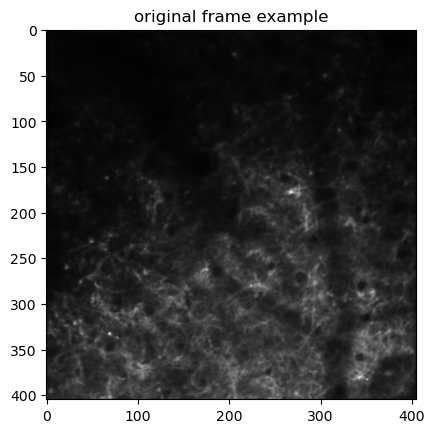

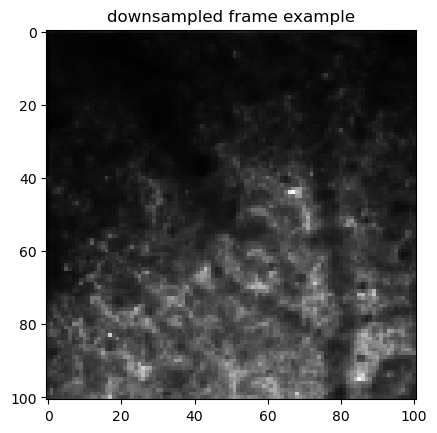

In [4]:
tiff = get_tiff(ds)

# downsample (to speed up cross-validation)
tiff = downsample_tiff_avg(tiff, n=downs_fact)

In [5]:
# flattening movie to input it to NMF (negative *matrix* factorisation works on matrices, not tensors like movies)
tiff_flat = np.reshape(tiff, (tiff.shape[0] , tiff.shape[1]*tiff.shape[2]))
print(f'Shape of video as a matrix (input to NMF): {tiff_flat.shape}') 

Shape of video as a matrix (input to NMF): (3600, 164025)


# NMF on pixels

In [6]:
#initialising nmf and fitting to pixels
nmf_px = NMF(n_components=n_components)
nmf_px.fit(tiff_flat);

In [10]:
loading_imgs, loading_imgs_filt, rois_auto = compute_nmfpx_blur_thr(nmf_px, tiff.shape, blur_std=blur_std)

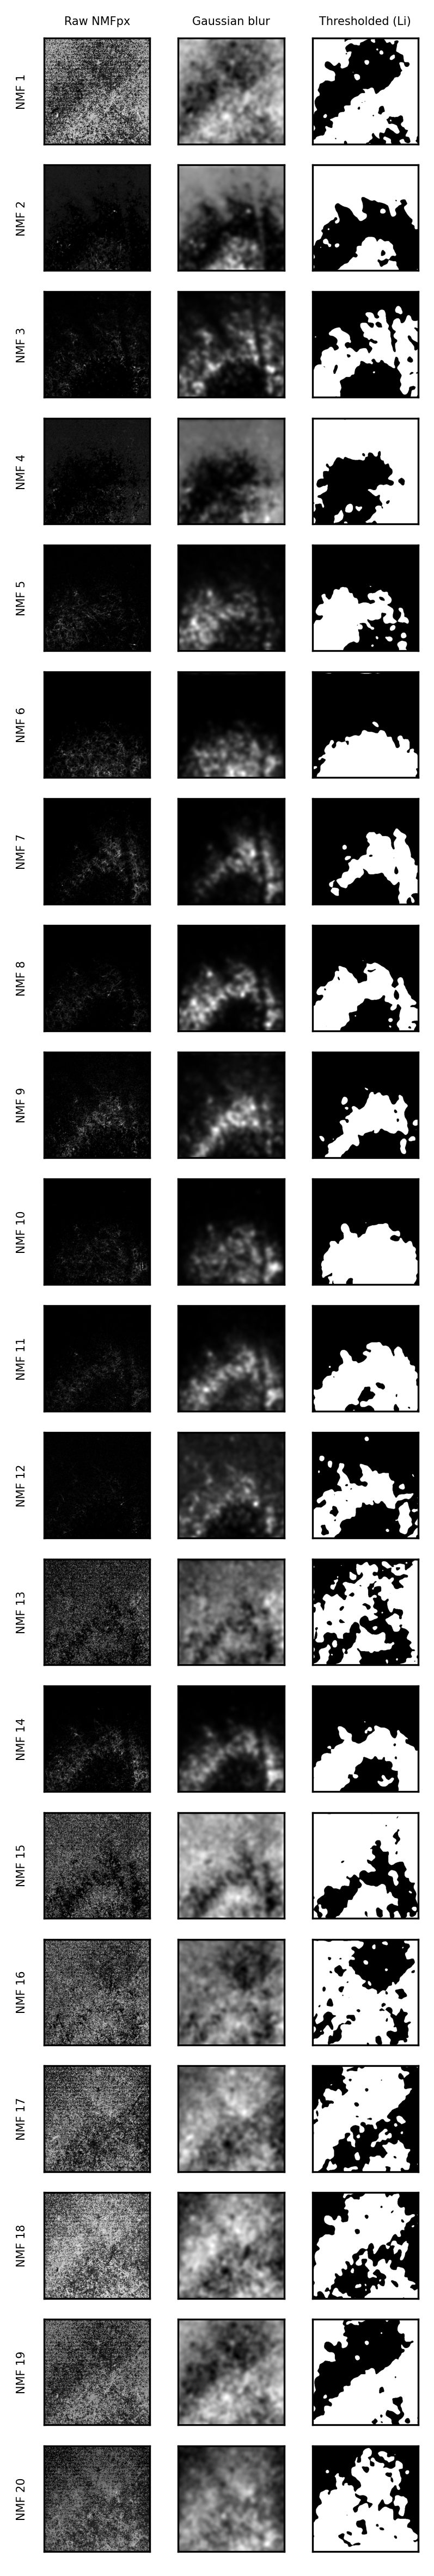

In [11]:
plot_nmfpx_blur_thr(loading_imgs, loading_imgs_filt, rois_auto)

In [12]:
# plotting all rois overlapped (issue: big rois might overlap and hide smaller ones)
def plot_rois_overlay(rois_auto, tiff_shape):

    n, x, y = tiff_shape
    plt.figure(figsize=(10,10))

    plt.figure(figsize=(10,10))

    for (i, roi) in enumerate(reversed(rois_auto)): # reversed to plot more obvious components first
        roi_scat = np.nonzero(roi)
        plt.scatter(roi_scat[1], -roi_scat[0], marker='s', s=9, alpha=0.1) # - is because of image processing convention
        plt.ylim((-y, 0))
        plt.xlim((0,x))
        plt.axis('off')
    plt.show()

<Figure size 1000x1000 with 0 Axes>

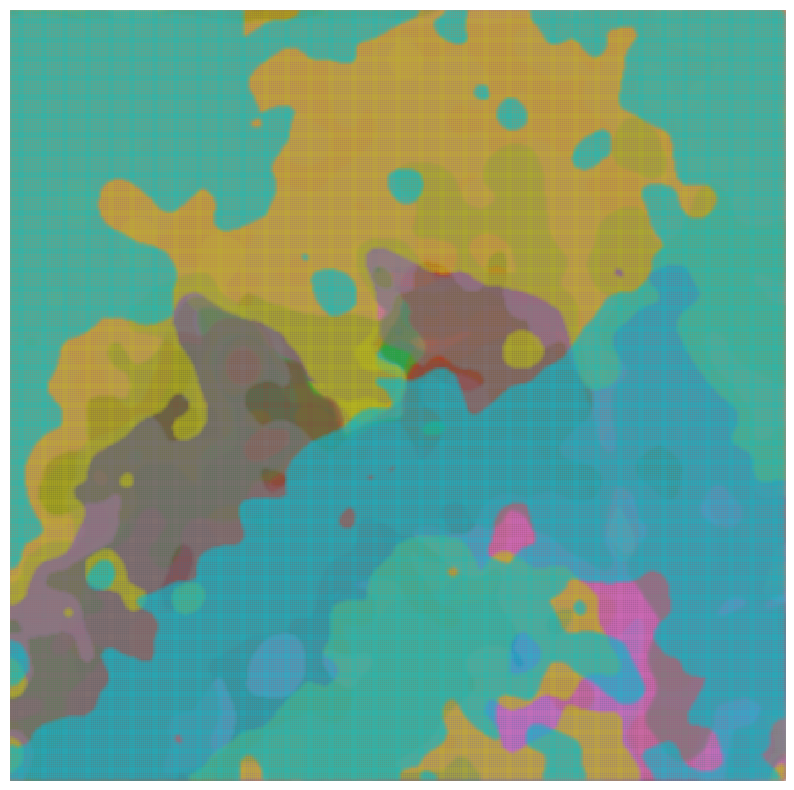

In [13]:
plot_rois_overlay(rois_auto, tiff.shape) # this will look ugly for too many components, also probably not the best viusalisation

In [17]:
conts, n_conts = get_roi_conts(rois_auto)

In [18]:
save_path = get_save_path(ds)
export_conts_fiji(conts, save_path)

SavePath:  /home/jure/Documents/code/barrel-patch_analysis/data/ani98_XXXX-XX-XX_a/patch_sz/


In [19]:
def plot_roi_conts_largest(conts, tiff_shape):
    
    # plots the largest contour in each ROI
    
    n, x, y = tiff_shape

    plt.figure(figsize=(10,10))

    for (i, roi_cont) in enumerate(conts):

        plt.plot(roi_cont[0][:,1], roi_cont[0][:,0], linewidth=5, alpha=0.7)

        plt.ylim((y, 0))
        plt.xlim((0,x))
        plt.axis('off')

        with open(save_path + f'nmf{i+1}_roi.txt', 'w') as f:
            for j in range(len(roi_cont[0])):
                f.write(f'{roi_cont[0][j,1]}    {roi_cont[0][j,0]}\n')

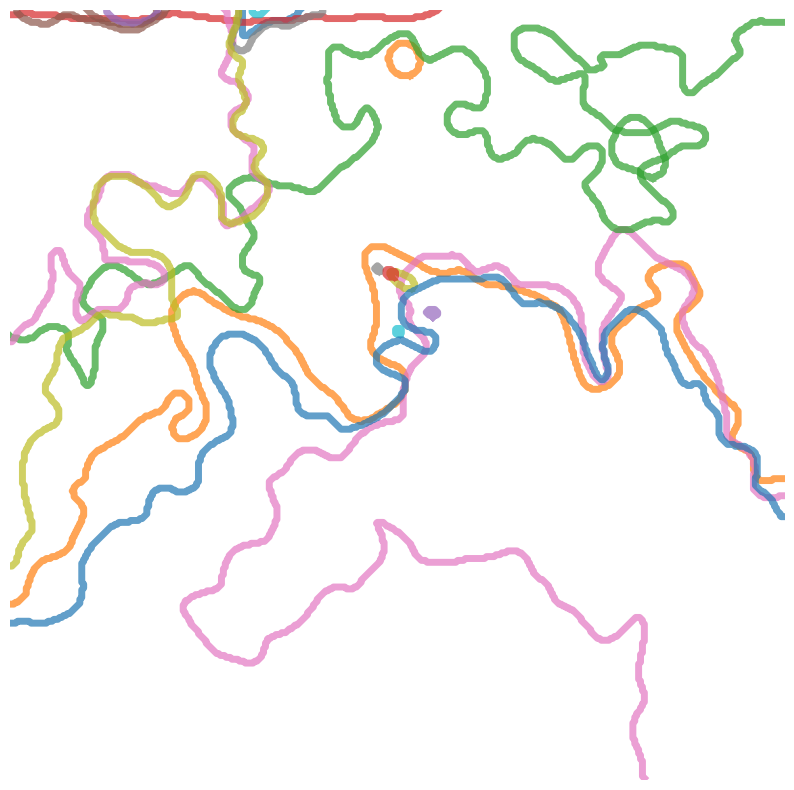

In [20]:
plot_roi_conts_largest(conts, tiff.shape)

In [71]:
# computing areas of patches and plotting distribution
def plot_roi_area_hist(rois_auto, n_bins=10):
    roi_areas = [np.sum(roi)*(resolution**2) for roi in rois_auto]
    plt.hist(roi_areas, n_bins);
    plt.title('patch area distribution')
    plt.xlabel('area (um^2)')

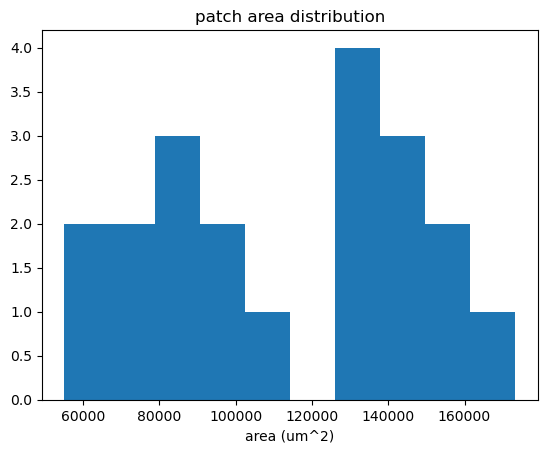

In [72]:
plot_roi_area_hist(rois_auto)

In [30]:
# looking at correlation (in the binary case this is somewhat equivalent to the percentage of overlap)
def plot_px_nmf_corr(nmf_px):
    plt.figure(figsize=(3,3), dpi=200)
    nmf_px_corrmat = np.corrcoef(nmf_px.components_) # correlation matrix of this
    plt.imshow(nmf_px_corrmat, vmin=0, vmax=1)
    plt.colorbar() 
    plt.xlabel('NMF component')
    plt.ylabel('NMF component')
    plt.xticks([])
    plt.yticks([])

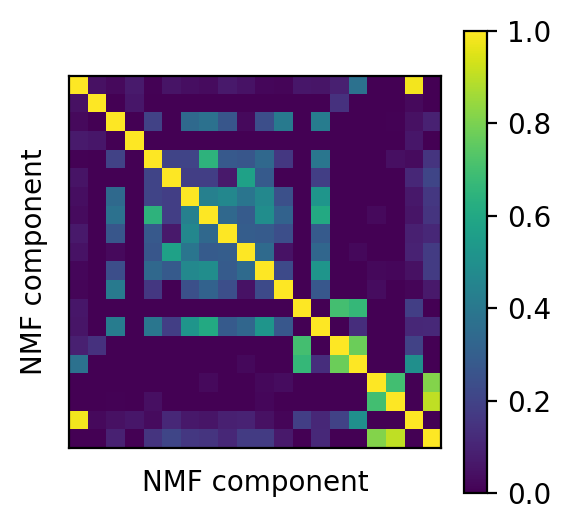

In [31]:
plot_px_nmf_corr(nmf_px)

# NMF on time

In [33]:
# Initialising nmf and fitting to time
nmf_t = NMF(n_components=n_components)
nmf_t.fit(tiff_flat.T);

NMF(n_components=20)

In [34]:
## saving all temporal components to list:
loading_times = []

for i in range(n_components):
    loading_time = nmf_t.components_[i, :]
    loading_times.append(loading_time)

In [75]:
def plot_roi_loading_time(rois_auto):
    n_components = len(rois_auto)

    fig, axs = plt.subplots(n_components, 2, figsize=(5, n_components), width_ratios=[1, 5], dpi=200)

    for (i, loading_time) in enumerate(loading_times):
        axs[i,0].imshow(rois_auto[i], cmap='gray')
        axs[i,0].xaxis.set_ticklabels('') 
        axs[i,0].yaxis.set_ticklabels('') 
        axs[i,0].xaxis.set_ticks([]) 
        axs[i,0].yaxis.set_ticks([]) 

        axs[i,1].plot(loading_time, c='grey')
        axs[i,1].axis('off')

        if i == 0:
            axs[i,0].set_title('PX component', fontsize=7)
            axs[i,1].set_title('T component (activation of PX component over time)', fontsize=7)

    plt.show()

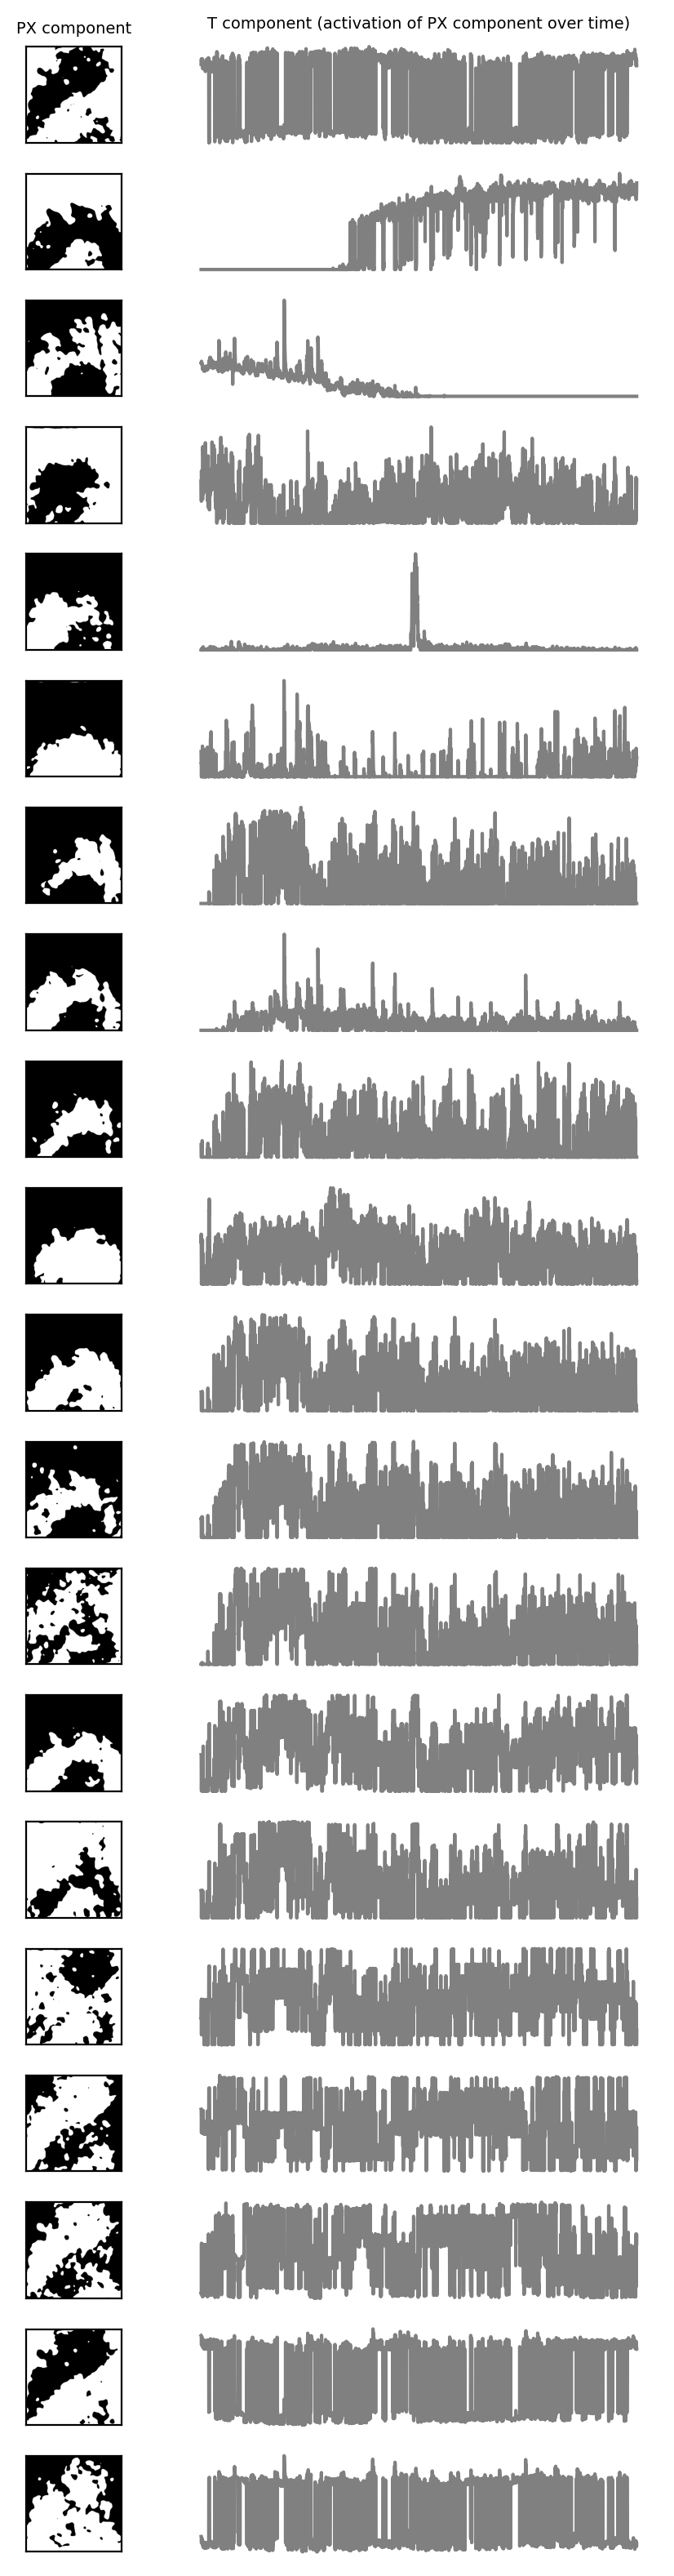

In [76]:
plot_roi_loading_time(rois_auto)

# Saving variables

In [36]:
# variables to save:
tiff_dimred_exp = {'loading_imgs': loading_imgs,
                   'loading_times': loading_times,
                   'rois_auto': rois_auto,
                   'conts': conts,
                   'roi_areas': roi_areas}

NameError: name 'roi_areas' is not defined

In [ ]:
np.save(f'{save_path}/export_tiff_dimred.npy', tiff_dimred_exp, allow_pickle=True)